In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram
import dask.dataframe as dd

In [114]:
root_dir = '/Users/zcaspar/codes/mit4320/'
coords = '30W10N'
dsE = xr.open_dataset(root_dir+'Eulerian_data_'+coords+'.nc')
dsL = dd.read_parquet(root_dir+'Lagrangian_data_'+coords,
                      columns=['lat','lon','trajectory','zonal_velocity','meridional_velocity']
                      ,engine='fastparquet').compute()
dsLmean = pd.read_parquet(root_dir+'Lagrangian_datamean_'+coords,
                          columns=['lat','lon','trajectory','mean_zonal_velocity','mean_meridional_velocity'])

In [115]:
lon_bins,lat_bins = np.linspace(dsL.lon.min(),dsL.lon.max(),10),np.linspace(dsL.lat.min(),dsL.lat.max(),10)

In [116]:
dsL['lon_cut'] = pd.cut(dsL['lon'],bins=lon_bins)
dsL['lat_cut'] = pd.cut(dsL['lat'],bins=lat_bins)
dsLmean['lon_cut'] = pd.cut(dsLmean['lon'],bins=lon_bins)
dsLmean['lat_cut'] = pd.cut(dsLmean['lat'],bins=lat_bins)
#dsL['time_cut'] = pd.cut(dsL.index,bins=10)

#### List of figures

1) Dans une sous division (1 en moyenne energétique et 1 moins) : evolution dans le temps du nombre de flotteurs + champ Eulérien d'anomalie 

2) Sur toute la grille : nombre de flotteurs par ss-divisions, EKE moyen

In [117]:
dsL['zonal_velocity_residual'] = (dsL['zonal_velocity'] - dsLmean['mean_zonal_velocity'])**2
dsL['meridional_velocity_residual'] = (dsL['meridional_velocity'] - dsLmean['mean_meridional_velocity'])**2
dsL['EKE'] = dsL['zonal_velocity_residual'] + dsL['meridional_velocity_residual']

In [118]:
EKE_L = dsL.groupby(['lon_cut','lat_cut',dsL.index]).mean().EKE
EKE_L = EKE_L.reset_index()
EKE_L['lon_bin'] = EKE_L.lon_cut.apply(lambda x :x.mid)
EKE_L['lat_bin'] = EKE_L.lat_cut.apply(lambda x :x.mid)
EKE_L = EKE_L.drop(columns=['lon_cut','lat_cut'])
EKE_L = EKE_L.set_index(['lon_bin','lat_bin','time'])
EKE_L = EKE_L.to_xarray()#array()
EKE_L

<xarray.Dataset>
Dimensions:  (lon_bin: 9, lat_bin: 9, time: 6570)
Coordinates:
  * lon_bin  (lon_bin) float64 -29.94 -29.83 -29.72 ... -29.28 -29.17 -29.06
  * lat_bin  (lat_bin) float64 10.06 10.17 10.28 10.39 ... 10.72 10.83 10.94
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-09T01:00:00
Data variables:
    EKE      (lon_bin, lat_bin, time) float64 nan nan nan nan ... nan nan nan

In [119]:
nb_flts = dsL.groupby(['lon_cut','lat_cut',dsL.index]).count().lat

In [120]:
nb_flts = nb_flts.reset_index()
nb_flts['lon_bin'] = nb_flts.lon_cut.apply(lambda x :x.mid)
nb_flts['lat_bin'] = nb_flts.lat_cut.apply(lambda x :x.mid)
nb_flts = nb_flts.drop(columns=['lon_cut','lat_cut'])

In [121]:
nb_flts = nb_flts.set_index(['lon_bin','lat_bin','time'])

nb_flts = nb_flts.to_xarray()#array()
nb_flts

_nb_flts = nb_flts.sel(time=dsE.time.values,method='nearest')

_nb_flts = _nb_flts.where(_nb_flts.lat>0,drop=True)

In [122]:
dsE['SSU_residual'] = (dsE.SSU_rot-dsE.SSU_rot.mean('time'))**2
dsE['SSV_residual'] = (dsE.SSV_rot-dsE.SSV_rot.mean('time'))**2
dsE['EKE'] = dsE['SSU_residual'] + dsE['SSV_residual']

In [123]:
N = histogram(dsE.lon.rename('lon'), dsE.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['lon', 'lat']
             )#.persist()

In [124]:
ds_binned = (histogram(dsE.lon.rename('lon'), dsE.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=dsE['EKE'].fillna(0.),
                       dim=['lon','lat'])/(N)).rename('E_SSU_residual').assign_coords({'time':dsE.time.values})

In [125]:
EKE_L

<xarray.Dataset>
Dimensions:  (lon_bin: 9, lat_bin: 9, time: 6570)
Coordinates:
  * lon_bin  (lon_bin) float64 -29.94 -29.83 -29.72 ... -29.28 -29.17 -29.06
  * lat_bin  (lat_bin) float64 10.06 10.17 10.28 10.39 ... 10.72 10.83 10.94
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-09T01:00:00
Data variables:
    EKE      (lon_bin, lat_bin, time) float64 nan nan nan nan ... nan nan nan

Mean Eulerian EKE in the bin :  0.03972304
Mean Lagrangian EKE in the bin :  0.03723455446274777
Ratio mean EKE in the bin :  0.9373541326706348


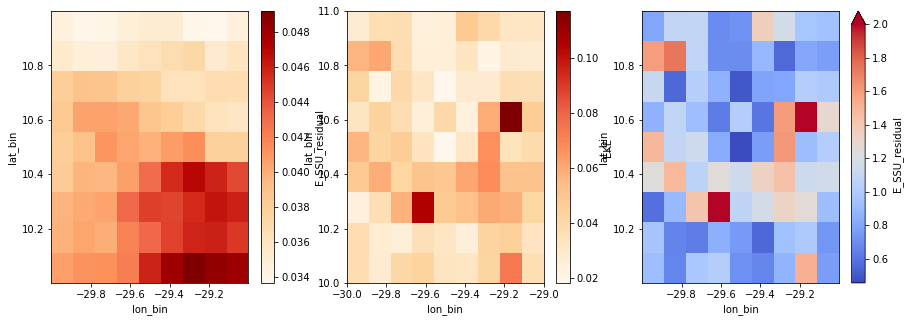

In [126]:
#Eulerian vs Lagrangian EKE in the bin
print('Mean Eulerian EKE in the bin : ', dsE.EKE.mean(['lon','lat','time']).values)
print('Mean Lagrangian EKE in the bin : ', dsL.EKE.mean())
print('Ratio mean EKE in the bin : ', dsL.EKE.mean()/dsE.EKE.mean(['lon','lat','time']).values)

fig,axs = plt.subplots(1,3,figsize=(15,5))
(ds_binned).mean('time').plot(cmap='OrRd',y='lat_bin',ax=axs[0])
(EKE_L.EKE).mean('time').plot(cmap='OrRd',y='lat_bin',ax=axs[1])
(EKE_L.EKE.mean('time').values/ds_binned.mean('time')).plot(cmap='coolwarm',y='lat_bin',ax=axs[2],vmax=2)

In [127]:
#dsE['nb_flts'] = _nb_flts.lat
y = _nb_flts.lat.mean(['lon_bin','lat_bin'])
x = (ds_binned).mean(['lon_bin','lat_bin'])

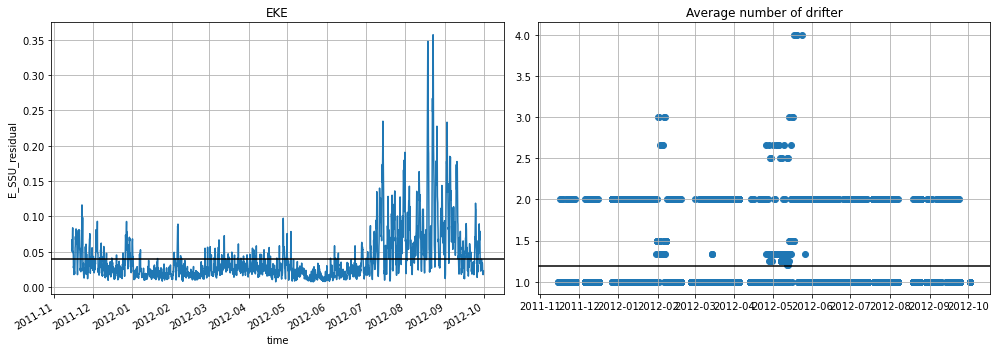

In [128]:
fig,axs = plt.subplots(1,2,figsize=(14,5))
ax = axs[0]
x.plot(ax=ax)
ax.grid();ax.set_title('EKE');
ax.axhline(x.mean(),c='k');
ax = axs[1]
ax.scatter(y.time,(y).values);
ax.axhline(y.mean(),c='k');
ax.grid();ax.set_title('Average number of drifter')
fig.tight_layout()

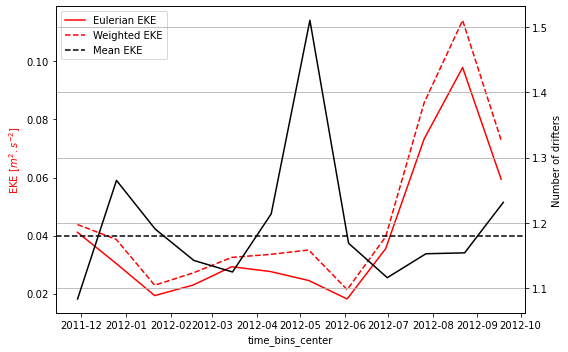

In [129]:
fig,ax = plt.subplots(figsize=(8,5))
x.groupby_bins('time',bins=12).mean().plot(ax=ax,c='r',label='Eulerian EKE')
(x*y.values).groupby_bins('time',bins=12).mean().plot(ax=ax,c='r',ls='--',label='Weighted EKE')
ax.axhline(x.mean('time'),c='k',ls='--',label='Mean EKE')
#ax.axhline((x*y.values).mean('time'),c='k',ls='--')
ax.set_ylabel(r'EKE [$m^2.s^{-2}$]',color='r');
ax.legend()
ax1 = ax.twinx()
y.groupby_bins('time',bins=12).mean().plot(ax=ax1,c='k')
ax1.set_ylabel('Number of drifters')
fig.tight_layout()

ax1.grid()

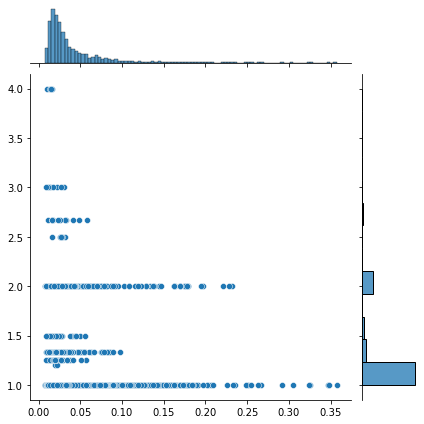

In [130]:
import seaborn as sns
sns.jointplot(x=x.values,y=y.values,kind='scatter')#,hue=x.time,add_legend=False

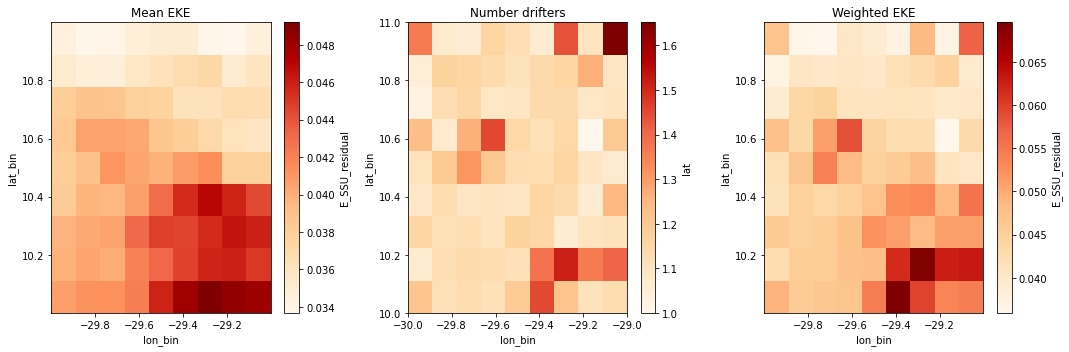

In [131]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax=axs[0]
ds_binned.mean('time').plot(ax=ax, cmap='OrRd',y='lat_bin')
ax.set_title('Mean EKE')
ax=axs[1]
_nb_flts.lat.mean('time').plot(ax=ax, cmap='OrRd',y='lat_bin')
ax.set_title('Number drifters')
ax=axs[2]
(ds_binned.mean('time')*_nb_flts.lat.mean('time').values).plot(ax=ax, cmap='OrRd',y='lat_bin')
ax.set_title('Weighted EKE')

fig.tight_layout()

In [132]:
ds_binned_month = ds_binned.groupby_bins('time',bins=13).mean()
nb_month = _nb_flts.groupby_bins('time',bins=13).mean()

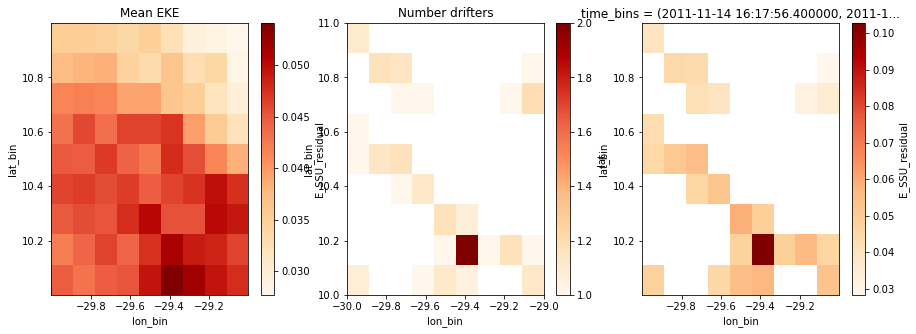

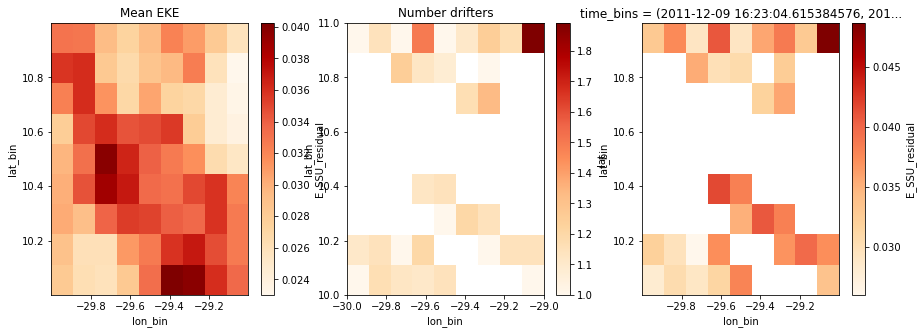

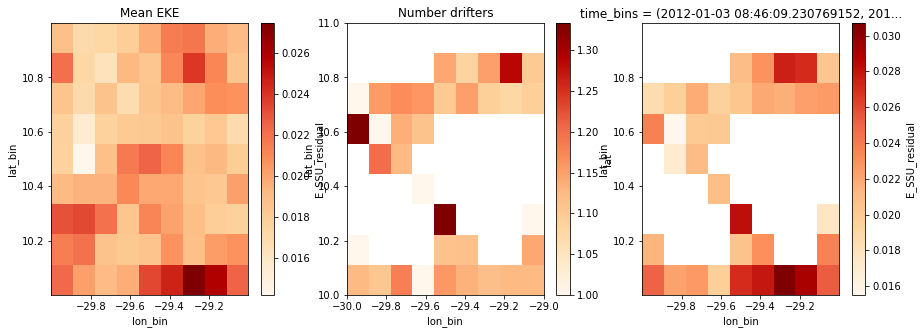

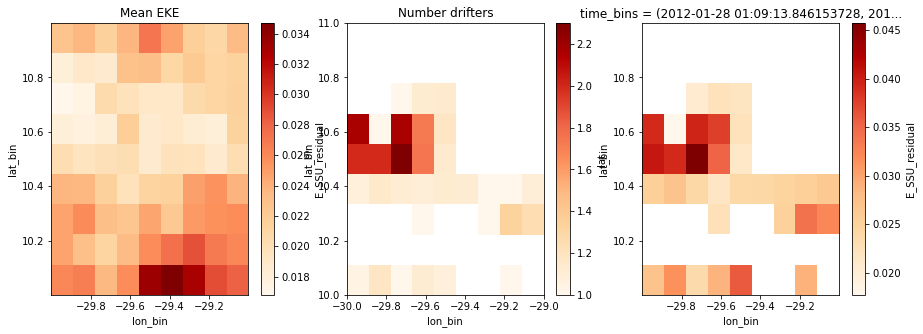

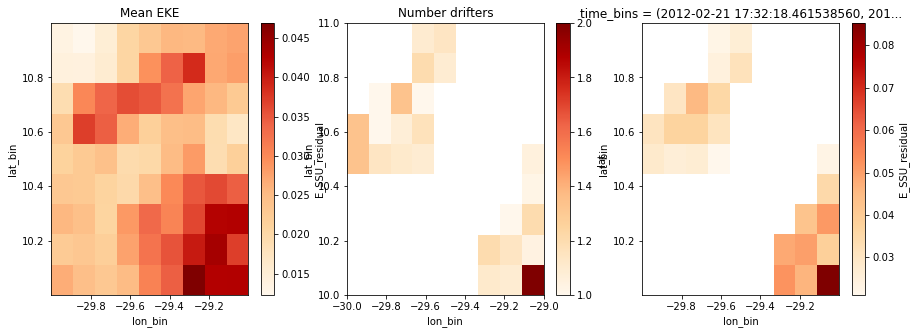

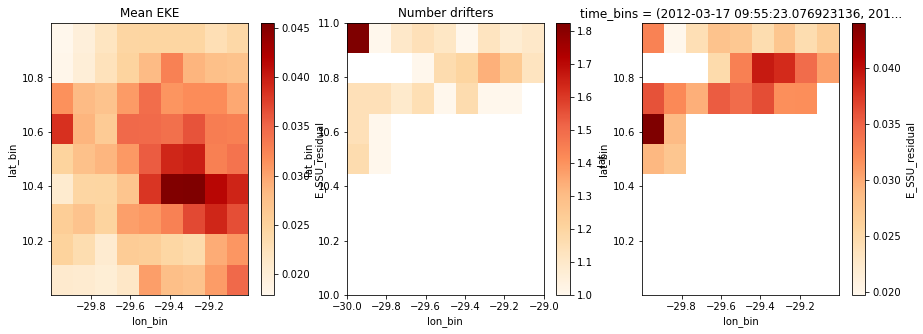

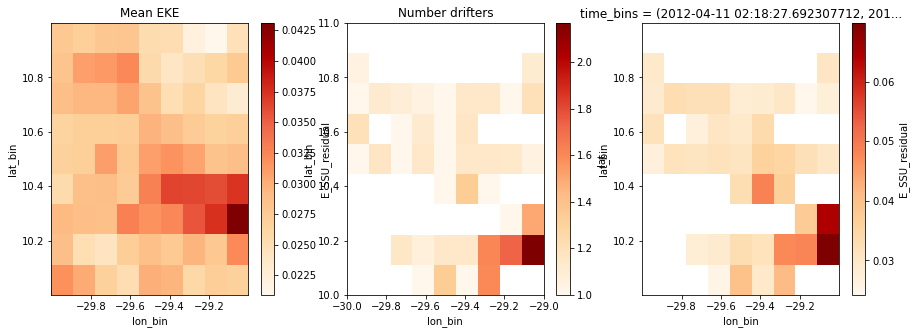

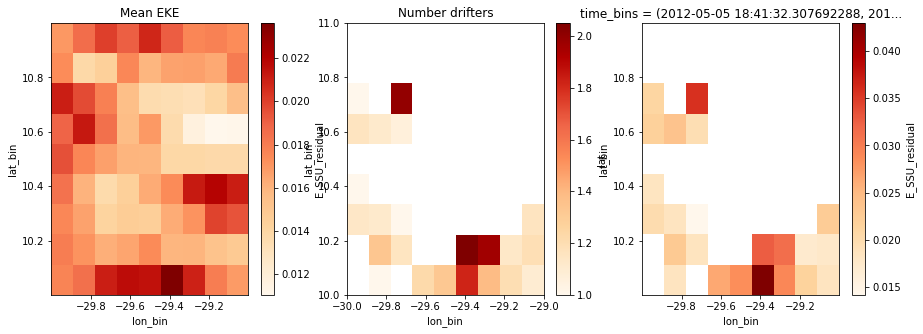

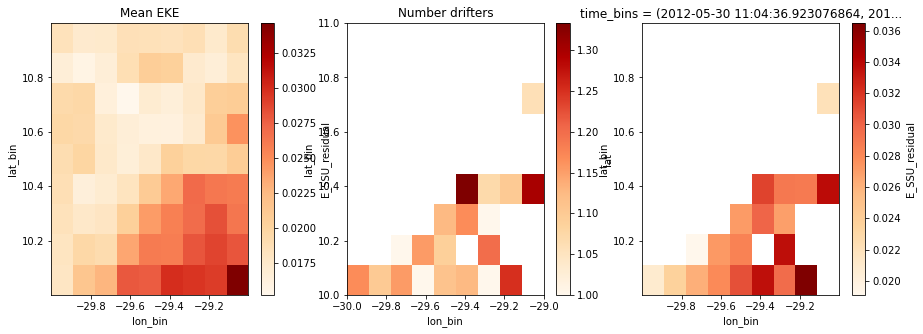

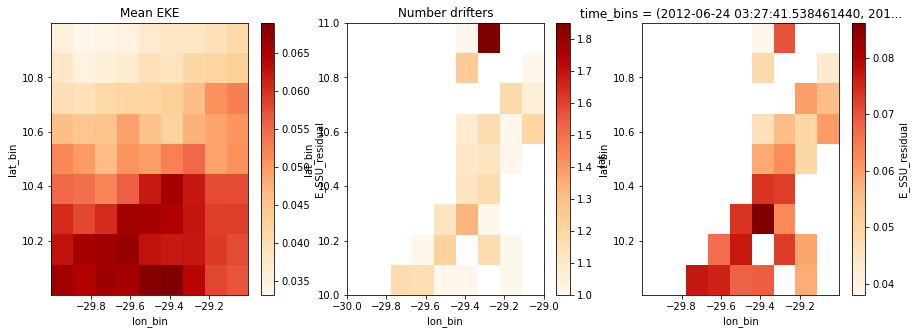

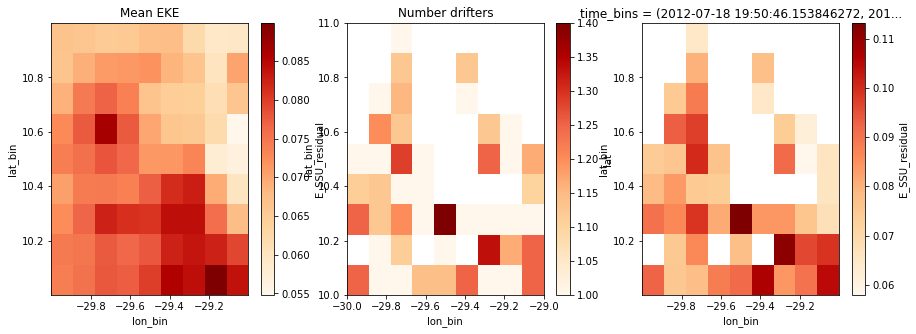

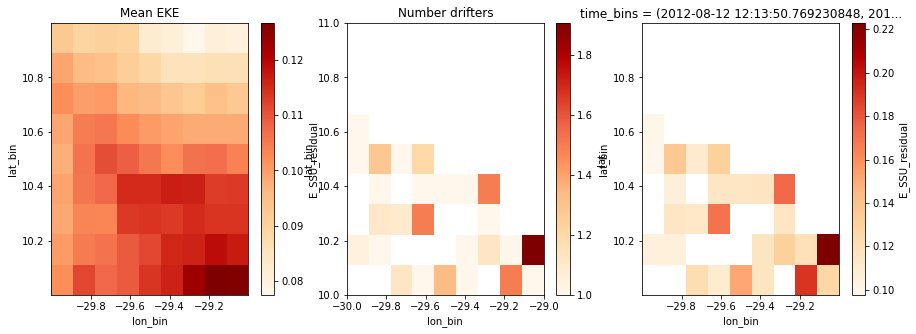

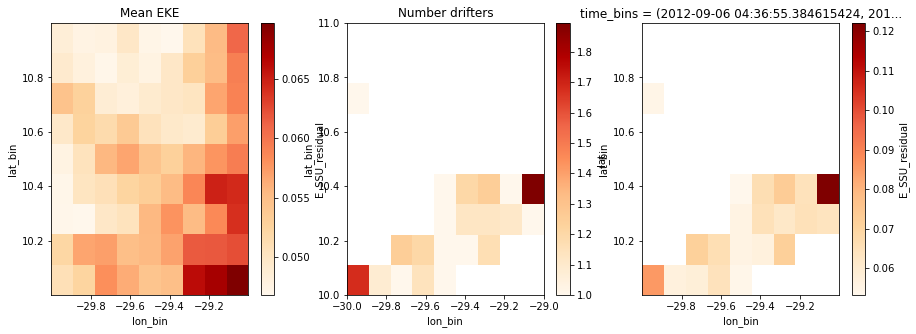

In [133]:
for t in range(nb_month.time_bins.size):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    x = ds_binned_month.isel(time_bins=t)
    y = nb_month.lat.isel(time_bins=t)
    ax=axs[0]
    x.plot(ax=ax, cmap='OrRd',y='lat_bin')
    ax.set_title('Mean EKE')
    ax=axs[1]
    y.plot(ax=ax, cmap='OrRd',y='lat_bin')
    ax.set_title('Number drifters')
    ax=axs[2]
    (x*y.values).plot(ax=ax, cmap='OrRd',y='lat_bin')
#    sns.jointplot(x=x.values.flatten(),y=y.values.flatten(),kind='scatter',ax=ax)#,hue=x.time,add_legend=False

In [136]:
i0,i1 = (-3,0), (0,-1)

flts0 = nb_flts.isel(lon_bin=i0[0],lat_bin=i0[1]).where(nb_flts.isel(lon_bin=i0[0],lat_bin=i0[1])>0,drop=True)
E0 = ds_binned.isel(lon_bin=i0[0],lat_bin=i0[1]).sel(time=flts0.time.values,method='nearest')

flts1 = nb_flts.isel(lon_bin=i1[0],lat_bin=i1[1]).where(nb_flts.isel(lon_bin=i1[0],lat_bin=i1[1])>0,drop=True)
E1 = ds_binned.isel(lon_bin=i1[0],lat_bin=i1[1]).sel(time=flts1.time.values,method='nearest')

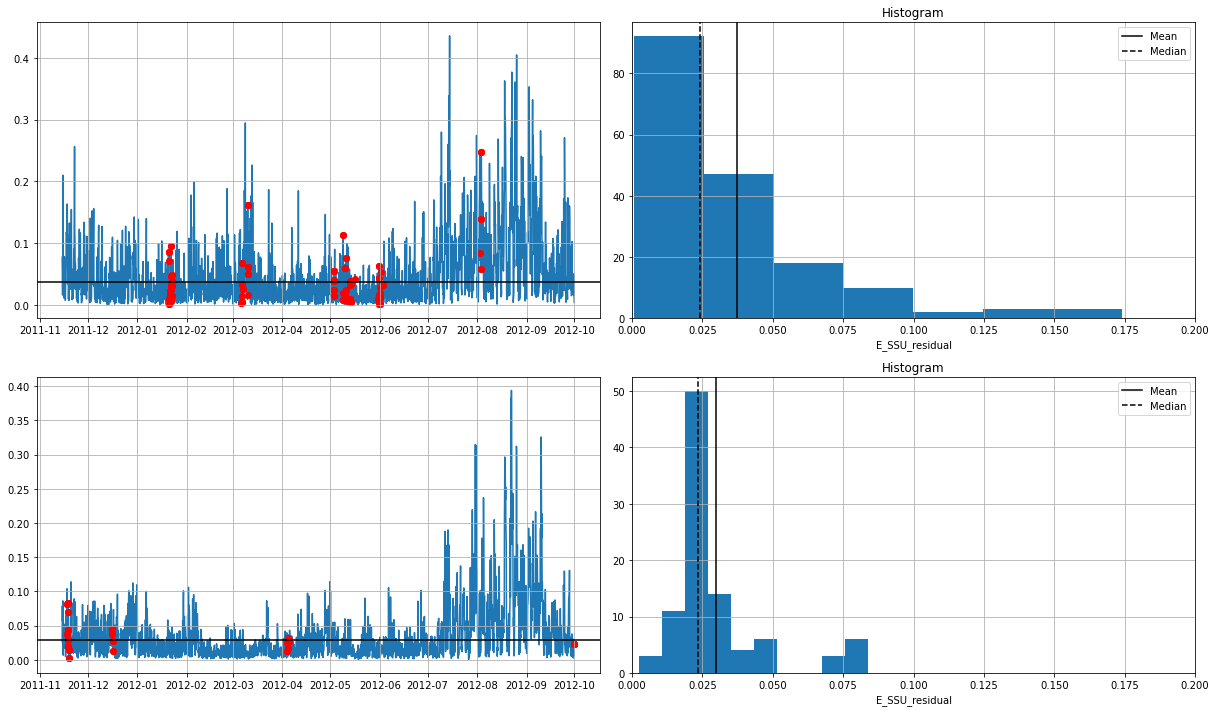

In [137]:
fig,axs = plt.subplots(2,2,figsize=(17,10),sharey=False)
for i,j,Ei in zip([i0,i1],range(2),[E0,E1]):
    ax = axs[j,:]
    ax[0].plot(ds_binned.time,ds_binned.isel(lon_bin=i[0],lat_bin=i[1]),zorder=-1)
    ax[0].scatter(Ei.time,Ei.values,c='r')
    ax[0].grid();
    ax[0].axhline(Ei.mean(),c='k')
    Ei.plot.hist(bins=10,ax=ax[1])
    ax[1].axvline(Ei.mean('time'),c='k',label='Mean');
    ax[1].axvline(Ei.quantile(0.5),c='k',ls='--',label='Median');
    ax[1].grid();ax[1].set_xlim(0,0.2);ax[1].set_title('Histogram')
    ax[1].legend()
fig.tight_layout()